# We analyse multiple trajectories for a smooth landscape with one hidden units, high learning rate and then characterize the diffusion.

In [5]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')
sys.path.append('ffmpeg-3.4.2-32bit-static/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies
import rbm_relu

In [18]:
#import dill
#dill.dump_session('./data_bruckner/data/notebookData/18_singleUnit_Diffusion-ReLU')

In [ ]:
#import dill
#dill.load_session('./data_bruckner/data/notebookData/18_singleUnit_Diffusion-ReLU')

In [2]:
Num_reps=5

In [ ]:
%%capture capt1
#Supress the output of the cell and save it to capt1

N = 100
beta = 1.
Num_configs = 1000000

#Generate spins using Gibbs Sampling MCMC
BM = bm.BM(N=N,nature='Spin')

#Define Couplings
BM.layer.couplings =  beta* (np.eye(N=N,k=1) + np.eye(N=N,k=-1) )
BM.layer.couplings[0,-1] += beta
BM.layer.couplings[-1,0] += beta
data = BM.gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=400) # N steps.

In [ ]:
#data_big    = []
results_big = []
RBM_big     = []
weights     = np.zeros([Num_reps,Num_configs*100/(100*1000),100])

for i in np.arange(Num_reps):
    
    #Train the model
    RBM = rbm_relu.RBM(visible = 'Spin', n_v=N, n_h = 1, hidden = 'ReLU',zero_field = False)
    results = RBM.fit(data,n_iter=100,verbose=0,learning_rate = 10.,record=['W'],record_interval=1000,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False);
    
    weights[i,:,:] = np.array(results['W'])[:,0,:]
    
    results_big.append(results)
    RBM_big.append(RBM)
    
    del results
    del RBM
    
    print i

Starting epoch 1


Jerome_scripts_Original/PGM/utilities.py:89: RuntimeWarning: overflow encountered in exp
  m[tmp] = np.exp(0.5 * X[tmp]**2) * (1- erf(X[tmp]/np.sqrt(2))) * np.sqrt(np.pi/2);
Jerome_scripts_Original/PGM/layer.py:511: RuntimeWarning: overflow encountered in divide
  p_plus = 1/(1+ etg_minus/etg_plus)


Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29


### Manual correction due to Periodic Boundary Conditions - If the position moves through the boundary, add or subtract the boundary value to it

In [13]:
def PBC_corr(peakCentre):
    temp_PC = np.copy(peakCentre)
    for i in np.argwhere(abs(peakCentre-np.roll(peakCentre,1))>50):
        if temp_PC[int(i)]<80:
            peakCentre[int(i):] += + 100
        elif temp_PC[int(i)]>20:
            peakCentre[int(i):] += - 100
        else:
            print 'Error'
    return peakCentre

In [14]:
peakCentre     = np.zeros([Num_reps,np.shape(weights)[1]])
peakCentre_PBC = np.zeros([Num_reps,np.shape(weights)[1]])
peakCentre_eqm = np.zeros([Num_reps,np.shape(weights)[1]])
for i in np.arange(Num_reps):
    peakCentre[i] = np.argmax(abs(weights[i,:,:]),axis=1)
    peakCentre_PBC[i]  = PBC_corr(np.copy(peakCentre[i]))
    peakCentre_eqm[i] += peakCentre_PBC[i,1] 

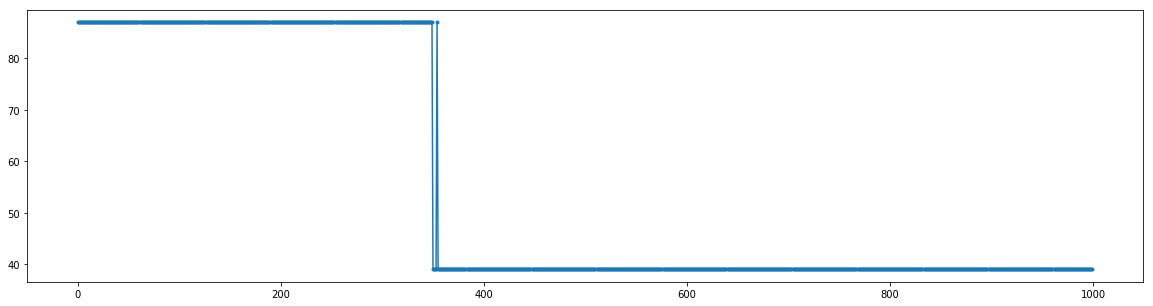

In [17]:
plt.figure(figsize=(20,5))
for i in np.arange(1):
    plt.plot(peakCentre[i],'.-')

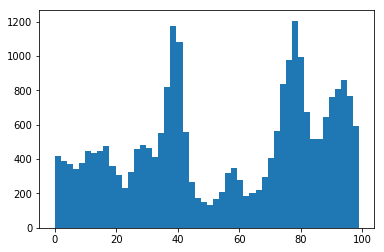

In [137]:
plt.hist(np.ndarray.flatten(peakCentre),50);plt.show()

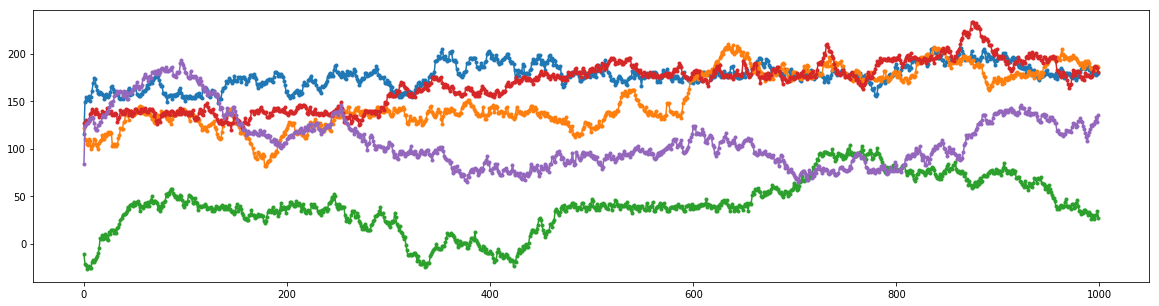

In [138]:
plt.figure(figsize=(20,5))
for i in np.arange(5):
    plt.plot(peakCentre_PBC[i],'.-')

### Diffusion (MSD) analysis for this peak:

In [140]:
MSD     = np.zeros([len(peakCentre_PBC)])
MSD_err = np.zeros([len(peakCentre_PBC)])

MSD     = np.average((peakCentre_PBC - peakCentre_eqm)**2,axis=0)
MSD_err = 2*np.std((peakCentre_PBC - peakCentre_eqm),axis=0)*np.sqrt(MSD)/(np.sqrt(Num_reps))

linear_coeff = np.polyfit(np.arange(np.shape(peakCentre_PBC)[1]),MSD,1)

Text(0.5,0,u'1/10 th of an Epoch')

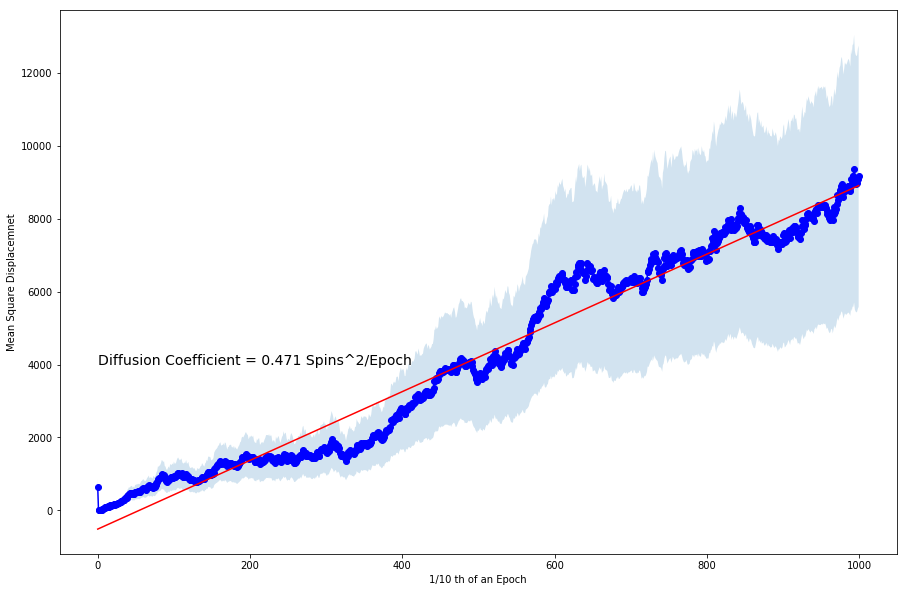

In [141]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(np.shape(peakCentre_PBC)[1]),MSD,'bo-')
plt.plot(np.arange(np.shape(peakCentre_PBC)[1]),np.arange(np.shape(peakCentre_PBC)[1])*linear_coeff[0] + linear_coeff[1],'r')
plt.fill_between(np.arange(np.shape(peakCentre_PBC)[1]), MSD-MSD_err, MSD+MSD_err,alpha=0.2)
plt.text(0,4000,'Diffusion Coefficient = {} Spins^2/Epoch'.format(np.round(linear_coeff[0]/20,3)),fontsize=14)
plt.ylabel('Mean Square Displacemnet')
plt.xlabel('1/10 th of an Epoch')